# DELPHI simulations on Resistive Wall + Resonator
## Looking at eigenvalues and eigenvectors output by DELPHI

### 0.1) Import libraries

In [2]:
%pylab notebook

from __future__ import division
from Impedance import *
from DELPHI import *
from string import *
from LHC_param import LHC_param
# from SPS_param import SPS_param
import itertools
import os
from  scipy.constants import c as clight
import scipy.special
from scipy.misc import factorial
import collections
#import skrf as rf


#from matplotlib import rc
#rc('font',**{'family':'serif','serif':['Times New Roman'],'size':12})
#rc('text', usetex=True)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### 0.2) Machine parameters

In [4]:
#Particle parameters (from LHC)
energy = 450.0 #in GeV
e,m0,c,E0 = proton_param()
machine,E,gamma,sigmaz,taub,R,Qx,Qxfrac,Qy,Qyfrac,Qs,eta,f0,omega0,omegas,dphase,Estr,V,h, M, en = LHC_param(E0,E=energy*1e9);

f0 = omega0/(2*np.pi)
fs = omegas/(2*np.pi)

print 'Qx = %f , Qxfrac = %f' % (Qx, Qxfrac)
print 'Qs = %f' % (Qs)
print 'omega0 = %f , omegas = %f' % (omega0, omegas)
print 'f0 = %f , fs = %f' % (omega0/(2.*np.pi), omegas/(2.*np.pi))

Qx = 64.310000 , Qxfrac = 0.310000
Qs = 0.004905
omega0 = 70657.404242 , omegas = 346.596859
f0 = 11245.475151 , fs = 55.162603


## 1) Resistive Wall + Broadband Resonnator Impedance Model

In [6]:
#Construction of the chamber
thick = 5e-3
    
Cu_lay = Cu300K_layer(thickness=thick)
vac_lay = vacuum_layer(thickness=np.inf)

chamber = construct_layers([Cu_lay,vac_lay])


#Frequency range
freq = freq_param(fmin=1e2,fmax=1e10,ftypescan=2,nflog=20,fadded=[],fmaxrefine=1e3,fminrefine=1e10,nrefine=500)


#Executables paths
#IW2D executables path
IW2Dexec='/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/IRIS/IW2D/ImpedanceWake2D/'

#IW2D result files location and names
ResultsDirIW2D='/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/IRIS/IW2D/ImpedanceWake2D/'
comment='_Thick'+str(thick*1e3)+'mm'



#Resistive wall Impedances simulations
imp_model_RW_R = []; wake_model_RW_R = []

iw_input_R = impedance_wake_input(machine='LHC',b=[10e-3],layers=chamber,fpar=freq,geometry='round',comment=comment)
imp_model_RW_R, wake_model_RW_R = imp_model_from_IW2D(iw_input_R,wake_calc=False,path=IW2Dexec,flagrm=True, lxplusbatch=None,dire=ResultsDirIW2D);



#Resonator model
imp_resonator = []; wake_resonator = []

#For info: Function header:
#imp_model_resonator(Rlist,frlist,Qlist,beta=1,wake_calc=False,fpar=freq_param(ftypescan=0,nflog=100),zpar=z_param(),listcomp=['Zxdip','Zydip']):

imp_resonator, wake_resonator = imp_model_resonator(np.array([1.0e3]),np.array([1.0e9]),np.array([1]),beta=1,wake_calc=False, fpar=freq,zpar=z_param(),listcomp=['Zxdip'])



#Total impedance calculation: RW + resonator
imp_total_RW_R = add_impedance_wake(imp_model_RW_R,imp_resonator,weightx=1,weighty=1)


#Writing impedance files
write_imp_wake_mod(imp_total_RW_R,name='RW_Resonator',listcomp=['Zl','Zxdip','Zydip','Zxquad','Zyquad'],dire=ResultsDirIW2D)

## 2) Computation with eigenmodesDELPHI_converged


### 2.1) Parameters for eigenmodesDELPHI_converged

In [7]:
#DELPHI parameters

#Number of bunches, coupled bunch mode, particles per bunch
M = 1 # 2748, 3564
nx = 0
Nb = 1e11

#Distribution
g,a,b=longdistribution_decomp(taub,typelong="Gaussian");

#Chromaticity
Qp = 0
omegaksi = Qp*omega0/eta

#Frequency downsampling
nevery = 1 

#Convergence criterion
crit = 5.e-3
abseps = 1.e-3



#Convert IW2D output into lists for DELPHI
#Here we take the Zxdip component
Zlist_RW_R = deepcopy(imp_total_RW_R[1].func[::nevery,:])
freqlist_RW_R = deepcopy(imp_total_RW_R[1].var[::nevery])

# Impedance and damper matrix coefficient computation
coefdamper_RW_R,coefZ_RW_R = computes_coef(f0,0,b,g[0],1,taub,0,M,Nb,gamma,Qx,particle='proton');

#Tables used for eigenmodesDELPHI output
lmaxold = 1
nmaxold = 1

eigenvalues_converged_RW_R = np.zeros(((2*lmaxold+1)*(nmaxold+1)), dtype = complex)
eigenvectors_converged_RW_R = np.zeros(((2*lmaxold+1)*(nmaxold+1),(2*lmaxold+1)*(nmaxold+1)), dtype = complex)

matdamperold = np.zeros((2*lmaxold+1,nmaxold+1,2*lmaxold+1,nmaxold+1),dtype=complex)
matZold = np.zeros((2*lmaxold+1,nmaxold+1,2*lmaxold+1,nmaxold+1),dtype=complex)

In [ ]:
n

<IPython.core.display.Javascript object>


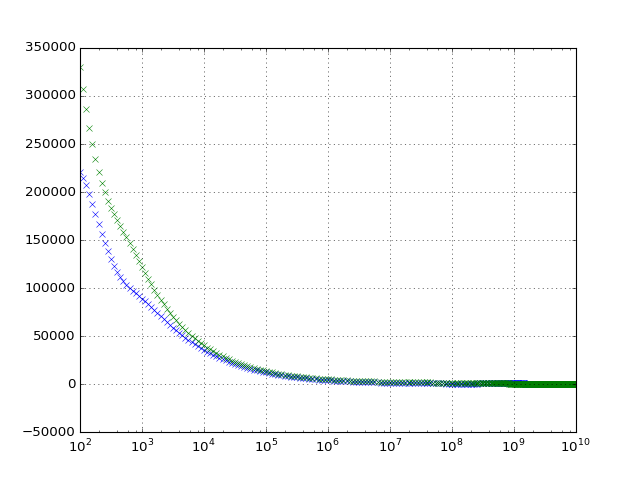

In [8]:
#Impedance plot

plt.close('all')

plt.figure(1)
plt.semilogx(freqlist_RW_R, Zlist_RW_R, 'x')
plt.grid()

plt.show()

### 2.2) Computation with eigenmodesDELPHI_converged

In [9]:
#Function header
#eigenmodesDELPHI_converged(nx,M,omegaksi,omega0,tunefrac,a,b,taub,g,Z,freqZ,coefdamper,coefZ,omegas,flag_trapz=0,flagdamperimp=0,d=None,freqd=None,kmax=5,crit=5.e-2,abseps=1.e-3,lmaxold=-1,nmaxold=-1,matdamperold=None,matZold=None,flageigenvect=False)

#Computation with eigenmodesDELPHI_converged
eigenvalues_converged_RW_R, eigenvectors_converged_RW_R, lmax0, nmax0, matdamperold, matZold = eigenmodesDELPHI_converged(nx,M,omegaksi,omega0,Qxfrac,a,b,taub,g,Zlist_RW_R,freqlist_RW_R,coefdamper_RW_R,coefZ_RW_R,omegas,flag_trapz=1,flagdamperimp=0,d=None,freqd=None,kmax=1,crit=crit,abseps=abseps,lmaxold=-1,nmaxold=-1,matdamperold=None,matZold=None,flageigenvect=True)


/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/IRIS/DELPHI/DELPHI_Python/DELPHI.py:171: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (damperold==None) or ( ( (l>lmaxold)or(lprime>lmaxold) ) or ( (n>nmaxold)or(nprime>nmaxold) ) ):
/afs/cern.ch/user/n/nbiancac/ln_work/scratch0/IRIS/DELPHI/DELPHI_Python/DELPHI.py:81: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (couplold==None) or ( ( (l>lmaxold)or(lprime>lmaxold) ) or ( (n>nmaxold)or(nprime>nmaxold) ) ):


In [10]:
#The eigenvalues are ordered by their imaginary part: the most unstable mode is first

print eigenvalues_converged_RW_R

[  3.46593630e+02 -3.67167788e-15j  -3.46600089e+02 -3.36505501e-15j
   3.46596542e+02 -8.06394116e-16j  -3.46597177e+02 -7.99459927e-16j
  -3.46596864e+02 -8.72603025e-17j   3.46596855e+02 -2.93985641e-17j
   6.93193725e+02 -6.99339969e-18j  -6.93193713e+02 +3.72834840e-19j
  -6.93193784e+02 +1.68212251e-18j   6.93193653e+02 +1.81182168e-18j
  -6.93194808e+02 +3.29758193e-17j   6.93192630e+02 +3.30100311e-17j
  -5.69693652e-05 +9.25244503e-09j  -1.36089442e-03 +1.94889398e-07j
  -1.41275376e-02 +4.10193457e-06j]


In [11]:
#The tuneshifts are ordered by their imaginary part: the most unstable mode is first

print eigenvalues_converged_RW_R/omega0

[  4.90526978e-03 -5.19645170e-20j  -4.90536119e-03 -4.76249452e-20j
   4.90531099e-03 -1.14127334e-20j  -4.90531999e-03 -1.13145952e-20j
  -4.90531555e-03 -1.23497747e-21j   4.90531543e-03 -4.16071952e-22j
   9.81063106e-03 -9.89761762e-23j  -9.81063090e-03 +5.27665635e-24j
  -9.81063190e-03 +2.38067408e-23j   9.81063005e-03 +2.56423470e-23j
  -9.81064639e-03 +4.66700123e-22j   9.81061556e-03 +4.67184317e-22j
  -8.06275942e-10 +1.30947990e-13j  -1.92604644e-08 +2.75823037e-12j
  -1.99944192e-07 +5.80538532e-11j]
